In [14]:
import gizmo_analysis as gizmo  # rename these packages for brevity
import utilities as ut  # rename these packages for brevity

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from astropy import units as u
from astropy import constants as cst

# from aqn import *
# from constants import *
import pickle
import scipy.stats as stats

from scipy.stats import bootstrap

# from fit_FIRE_cubes_functions import *
from mcmc_models import *

import emcee
from multiprocessing import Pool,cpu_count
import corner

In [18]:
def plot_distribution(func, R, parameters, name, log=True, velocity=False, temperature=False):
    plt.figure(dpi=300)
    plt.plot(R, func(R, parameters))
    # plt.plot(R_outer, rho_c_burkert_quad(R_outer.value, vh*10, r0*1.4))
    plt.title("Density Distribution, "+str(name))
    plt.xlabel("R [kpc]", size=20)
    plt.ylabel(r'$\rho$'+"  [kg$\cdot$m$^{-3}$]", size = 20)
    if log:
        plt.yscale('log')
    if velocity:
        plt.ylabel(r'$\Delta v$'+"  [m$\cdot$s$^{-1}$]", size = 20)
    if temperature:
        plt.ylabel(r'$T$'+" [K]", size=20)
        
    # plt.savefig("../visuals/FIRE-MCMC-"+quant+"-"+model_name+"-fit.png", bbox_inches='tight')
    # plt.savefig("../visuals/FIRE-MCMC-"+quant+"-"+model_name+"-fit.svg", bbox_inches='tight')
    plt.show()


In [19]:
########### Generalized NFW Profile #################################
def rho_dark_mat(R, parameters):
    rho_s, r_s, alpha, beta, gamma = parameters
        
    R_kpc   = R  * u.kpc
    rho_s_msol_kpc3 = rho_s * u.solMass / u.kpc**3 * 1e7
    r_s_kpc = r_s * u.kpc
    
    rho_s_kg_m3 = (rho_s_msol_kpc3).to(u.kg/u.m**3)
    
    return (( (2**((beta - gamma)/alpha)) * rho_s_kg_m3 ) / ( (R_kpc/r_s_kpc)**gamma * (1+(R_kpc/r_s_kpc)**alpha)**((beta - gamma)/alpha)  )).value

# $v_h$ [km$\cdot$(100s)$^{-1}$] = 3.3748557327868247 +- 0.0007224430100716527
# $r_0$ [kpc] = 3.6323001851347905 +- 0.006999449554973593

In [5]:
def rho_ioni_gas(x, parameters):
    a1, b1, c1 = parameters[0]*1e-23, parameters[1]*10, parameters[2] 
    a2, b2, c2 = parameters[3]*1e-23, parameters[4], parameters[5]
    a3         = parameters[6]*1e-24
    
    ret = a1 / (1+(x/b1)**2)**c1 + \
          a2 / (1+(x/b2)**2)**c2 + \
          a3
    
    return ret

# $a_1$ = 6.521713155920115 +- 0.1421848395197518
# $a_2$ = 0.2940077939925656 +- 0.00530334922788834
# $b_1$ = 29.072973590609415 +- 0.8640322865879939
# $b_2$ = 1.6812716453492722 +- 0.00812535252120406
# $c_1$ = 3.9044895415071528 +- 0.02812469134111113
# $c_2$ = 3.4656473013927394 +- 0.02927658626511007
# $a_3$ = 1.43427732961435 +- 0.0006910962557393511

In [20]:
def rho_neut_gas(x, parameters):
    a1, b1, c1 = parameters[0]*1e-21, parameters[1], parameters[2] 
    a2, b2, c2 = parameters[3]*1e-21, parameters[4], parameters[5]
    a3         = parameters[6]*1e-24
    
    ret = a1 / (1+(x/b1)**2)**c1 + \
          a2 / (1+(x/b2)**2)**c2 + \
          a3
    
    return ret

# $a_1$ = 8.97656111186945 +- 2.122373806714611
# $a_2$ = 2.213270305404448 +- 0.8432595656616187
# $b_1$ = 13.875013340031673 +- 6.871059801546976
# $b_2$ = 1.5018739204854163 +- 0.18611431393808028
# $c_1$ = 2.58047607932149 +- 0.2766151150009187
# $c_2$ = 1.1680782169590678 +- 0.045827214261955844
# $a_3$ = 29.693878727525025 +- 0.35916679889909797

In [21]:
def rho_dv_ioni(x, parameters):
    a1, b1, c1 = parameters[0]*1e5, parameters[1]*10, parameters[2]*10 
    a2, b2, c2 = parameters[3]*1e5, parameters[4], parameters[5]
    a3         = parameters[6]*1e5
    
    ret = a1 / (1+(x/b1)**2)**c1 + \
          a2 / (1+(x/b2)**2)**c2 + \
          a3
    
    return ret

# $a_1$ = 0.7594266933349966 +- 0.04657367182668136
# $a_2$ = 2.73608605904013 +- 0.4119655159177374
# $b_1$ = 2.5582050186794847 +- 0.9878666363827531
# $b_2$ = 1.004084602553337 +- 0.16233240935020687
# $c_1$ = 1.6631635389592465 +- 0.5006327879661947
# $c_2$ = 17.152525652652074 +- 8.324355925339894
# $a_3$ = 2.7163675354935055 +- 0.14398919053081505

In [11]:
def rho_dv_neut(x, parameters):
    a1, b1, c1 = parameters[0]*1e5, parameters[1]*1e2, parameters[2]*1e2 
    a2         = parameters[3]*1e5
    
    ret = a1 / (1+(x/b1)**2)**c1 + \
          a2
    
    return ret

# $a_1$ = 0.7817275122369671 +- 0.0804241495840021
# $b_1$ = 1.4514477940369448 +- 0.4148690807977011
# $c_1$ = 7.670255389377027 +- 4.431374895538939
# $a_2$ = 2.7444837892336853 +- 0.1308799874450566

In [15]:
def rho_temp(x, parameters):
    a1, b1, c1 = parameters[0]*1e7, parameters[1], parameters[2]
    a2, d2     = parameters[3]*1e7, parameters[4]
    a3         = parameters[5]*1e7
    
    ret = a1 / (1+(x/b1)**2)**c1 + \
          a2 * np.tanh(x-d2) + a3
    
    return ret

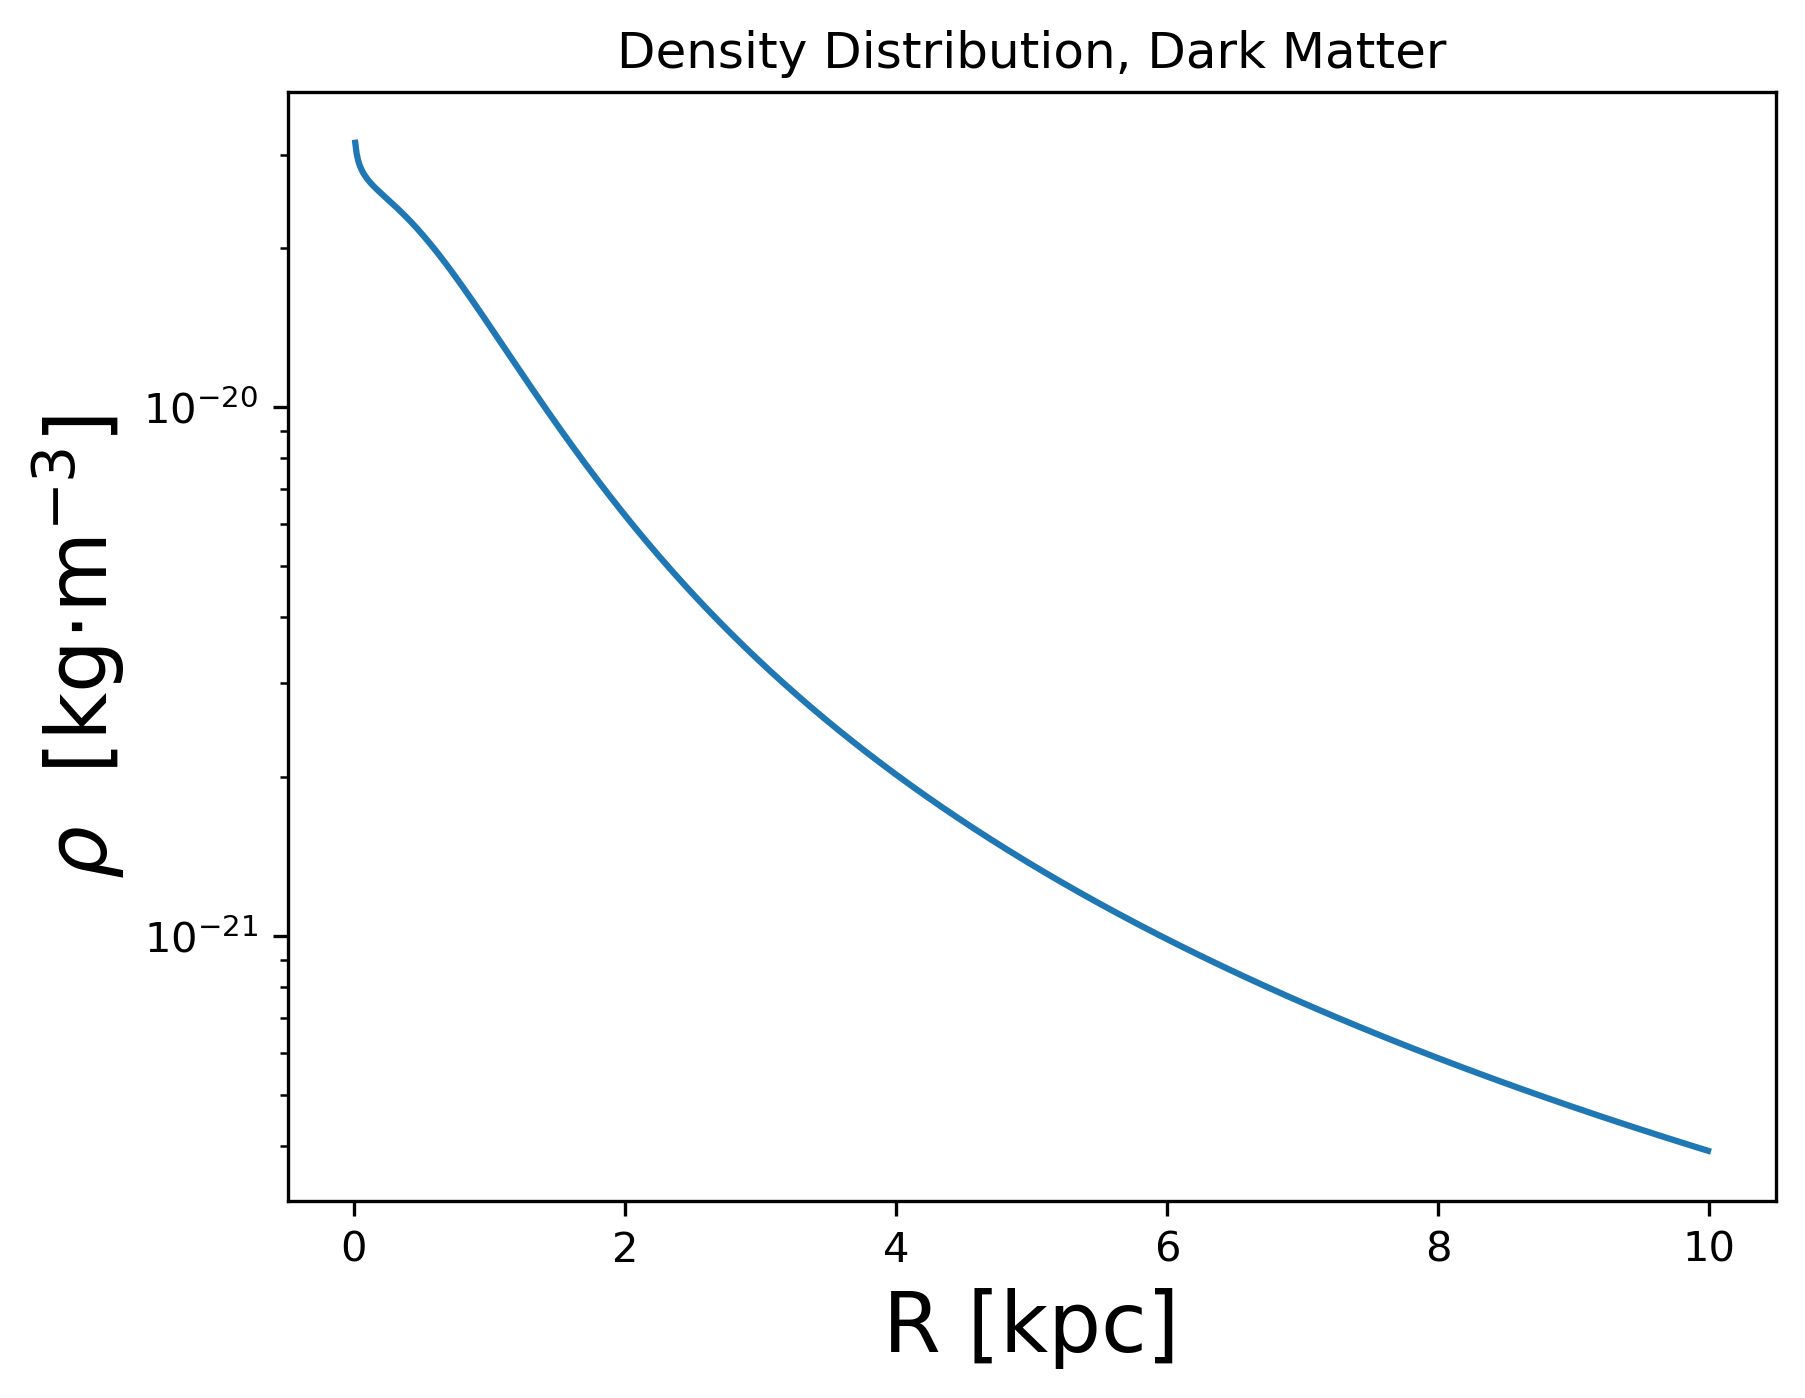

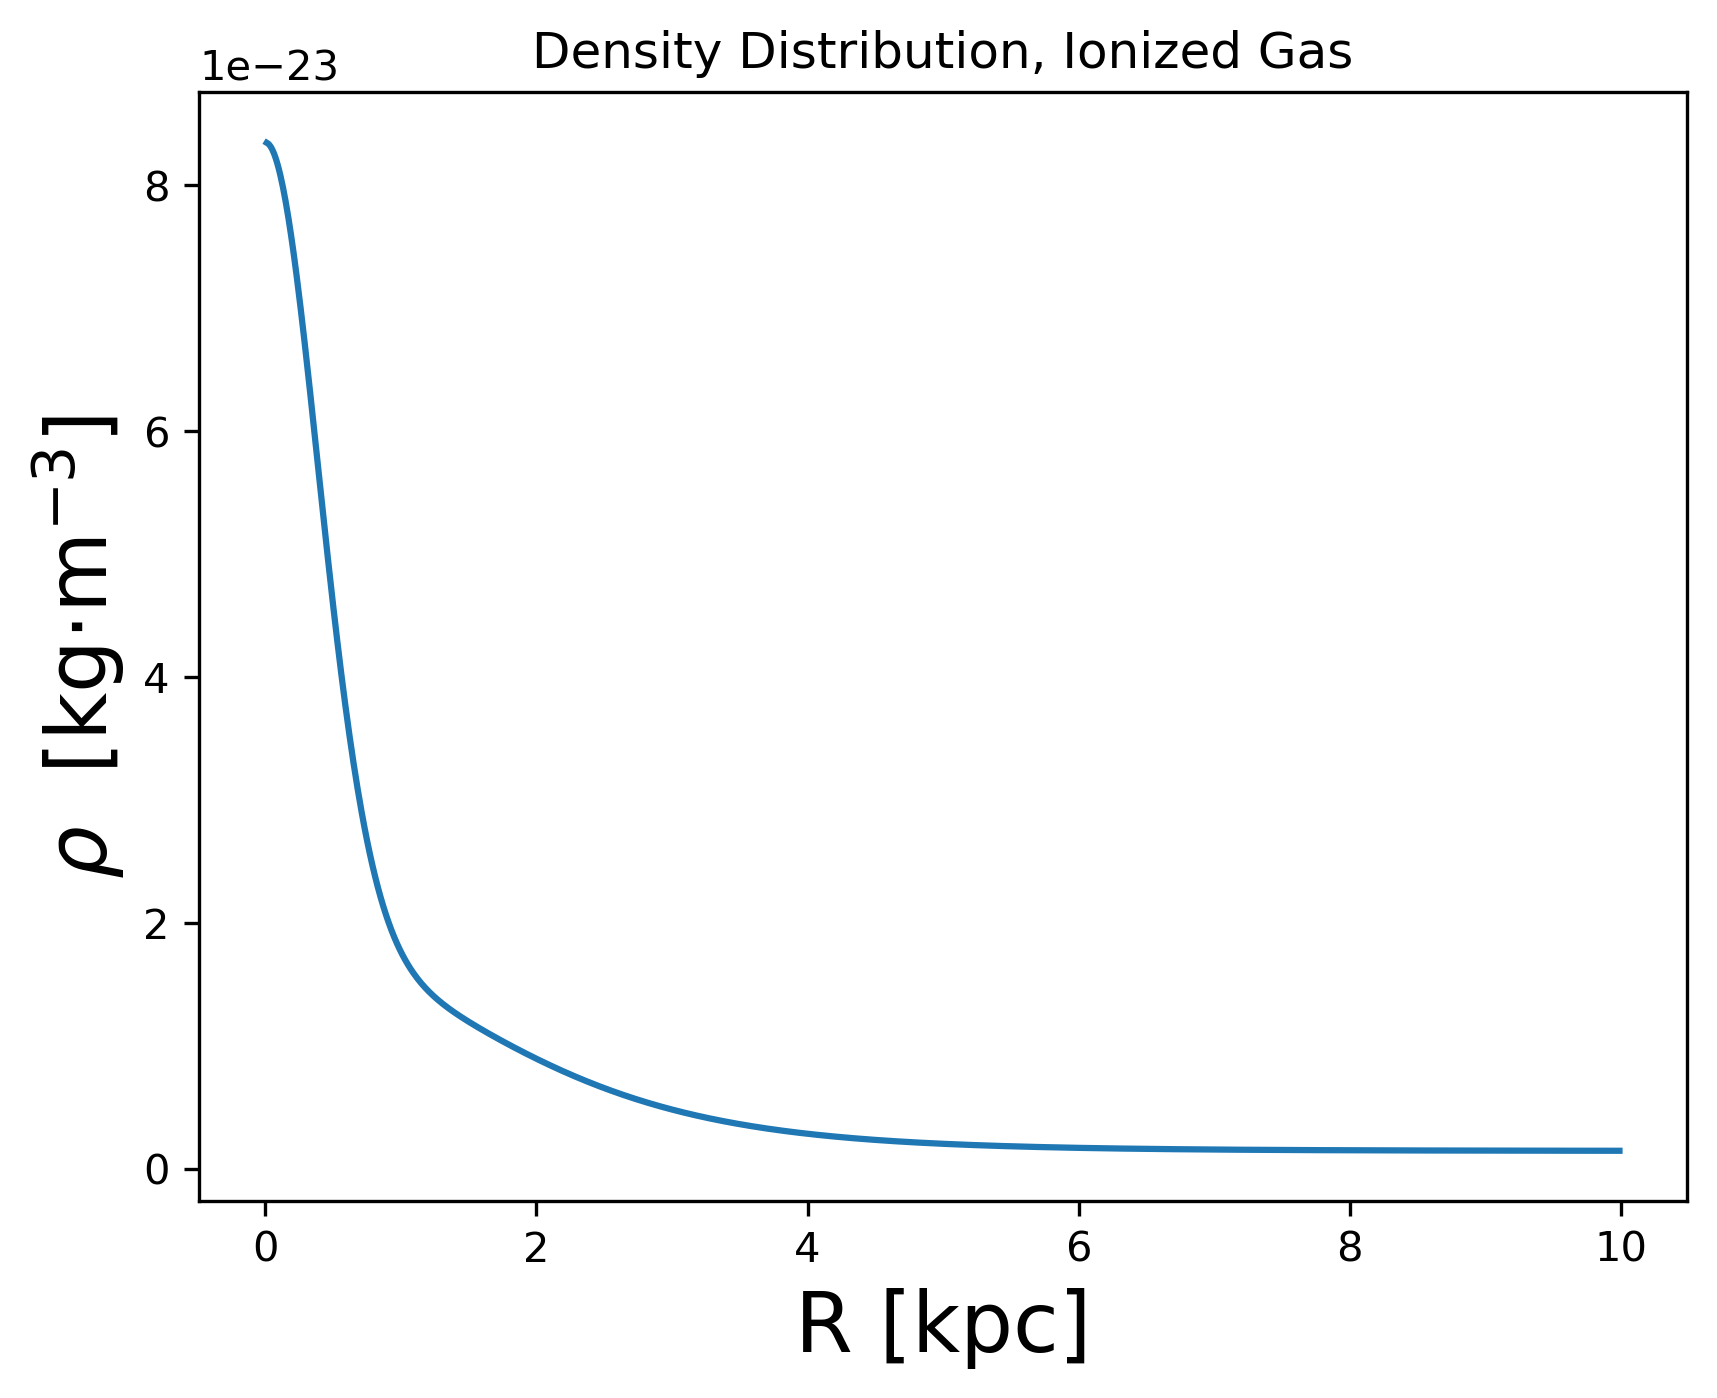

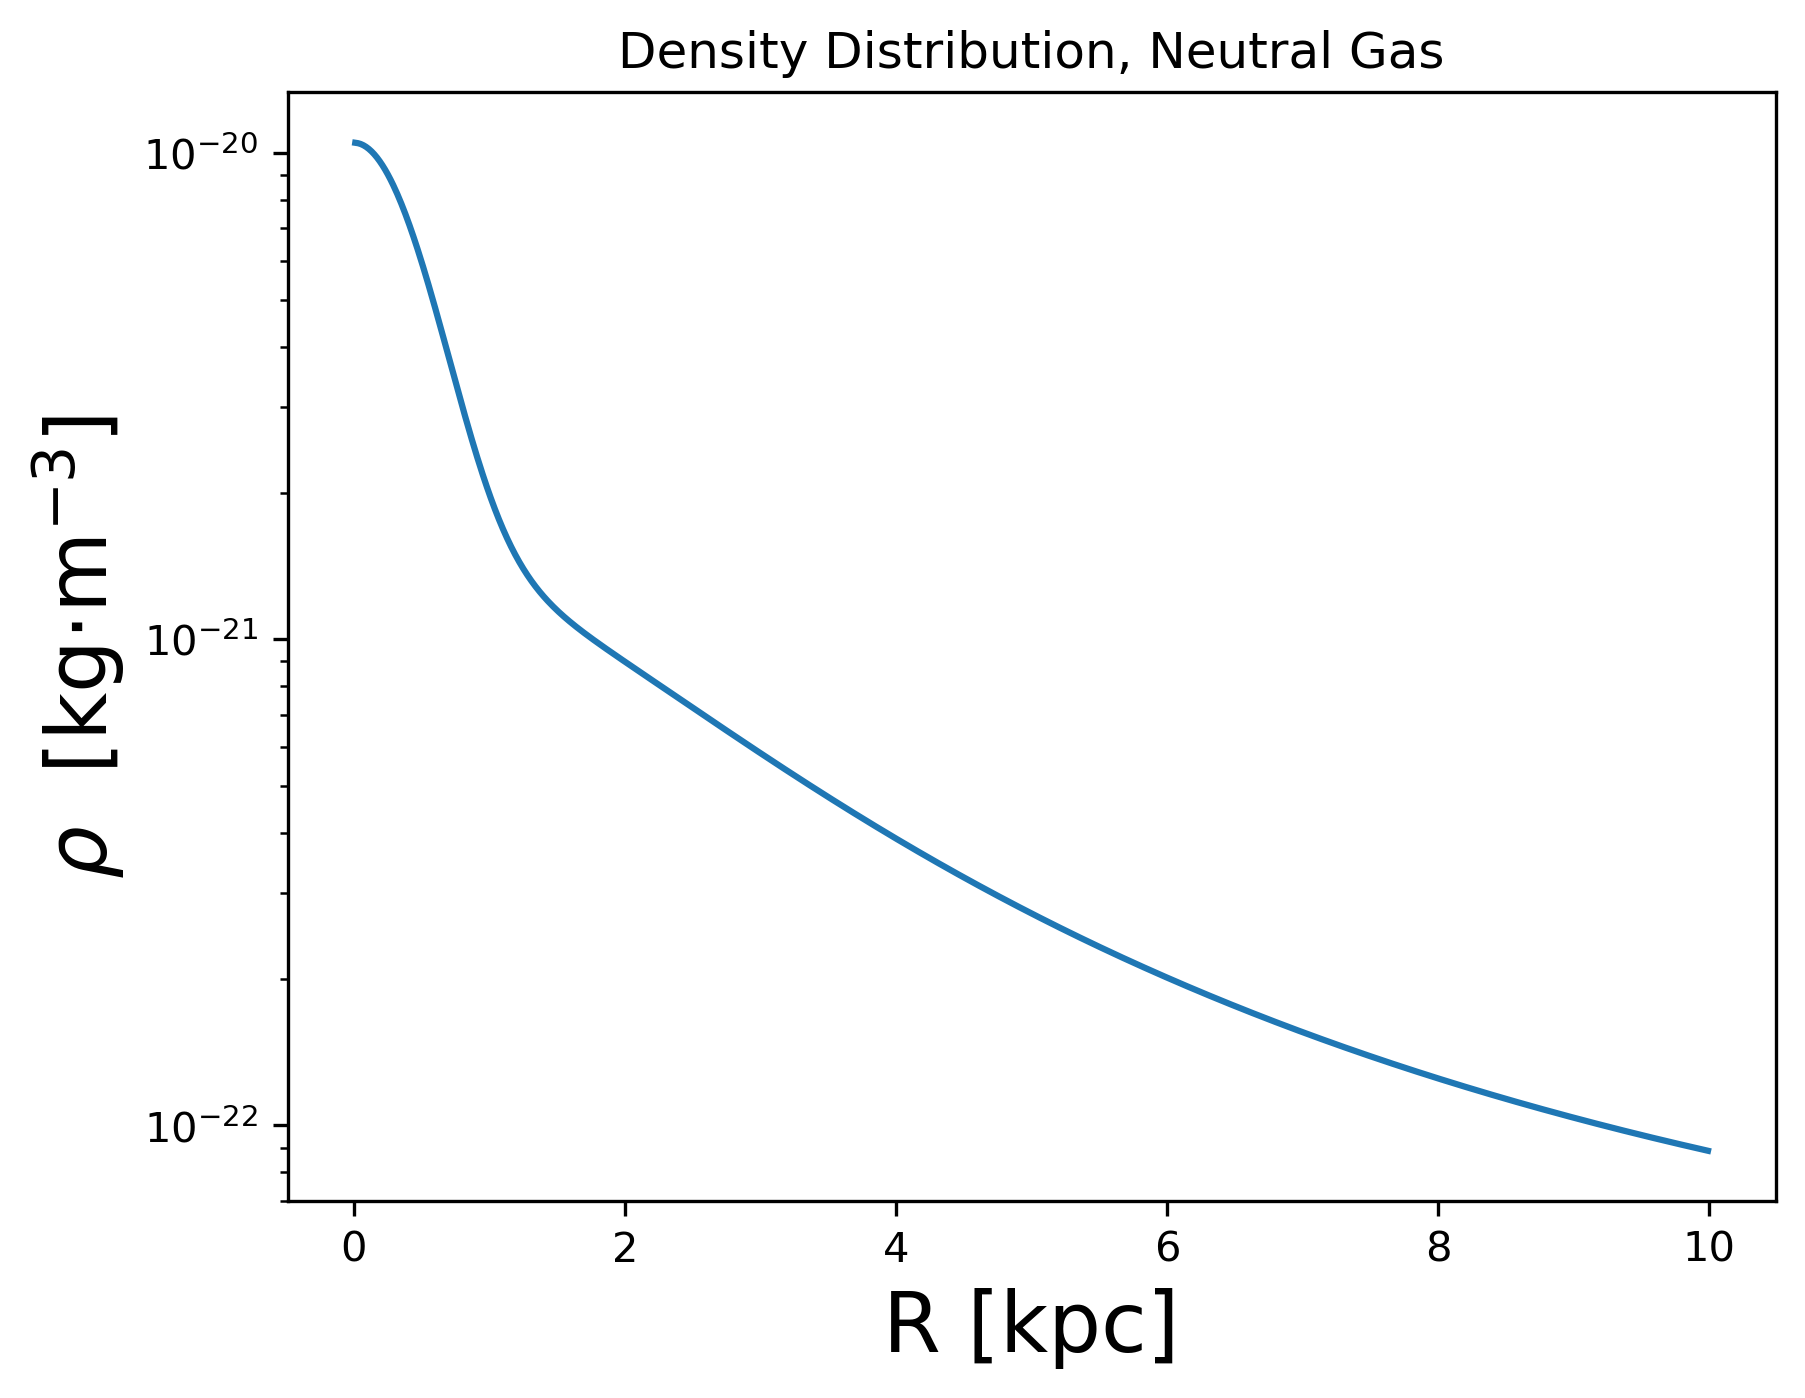

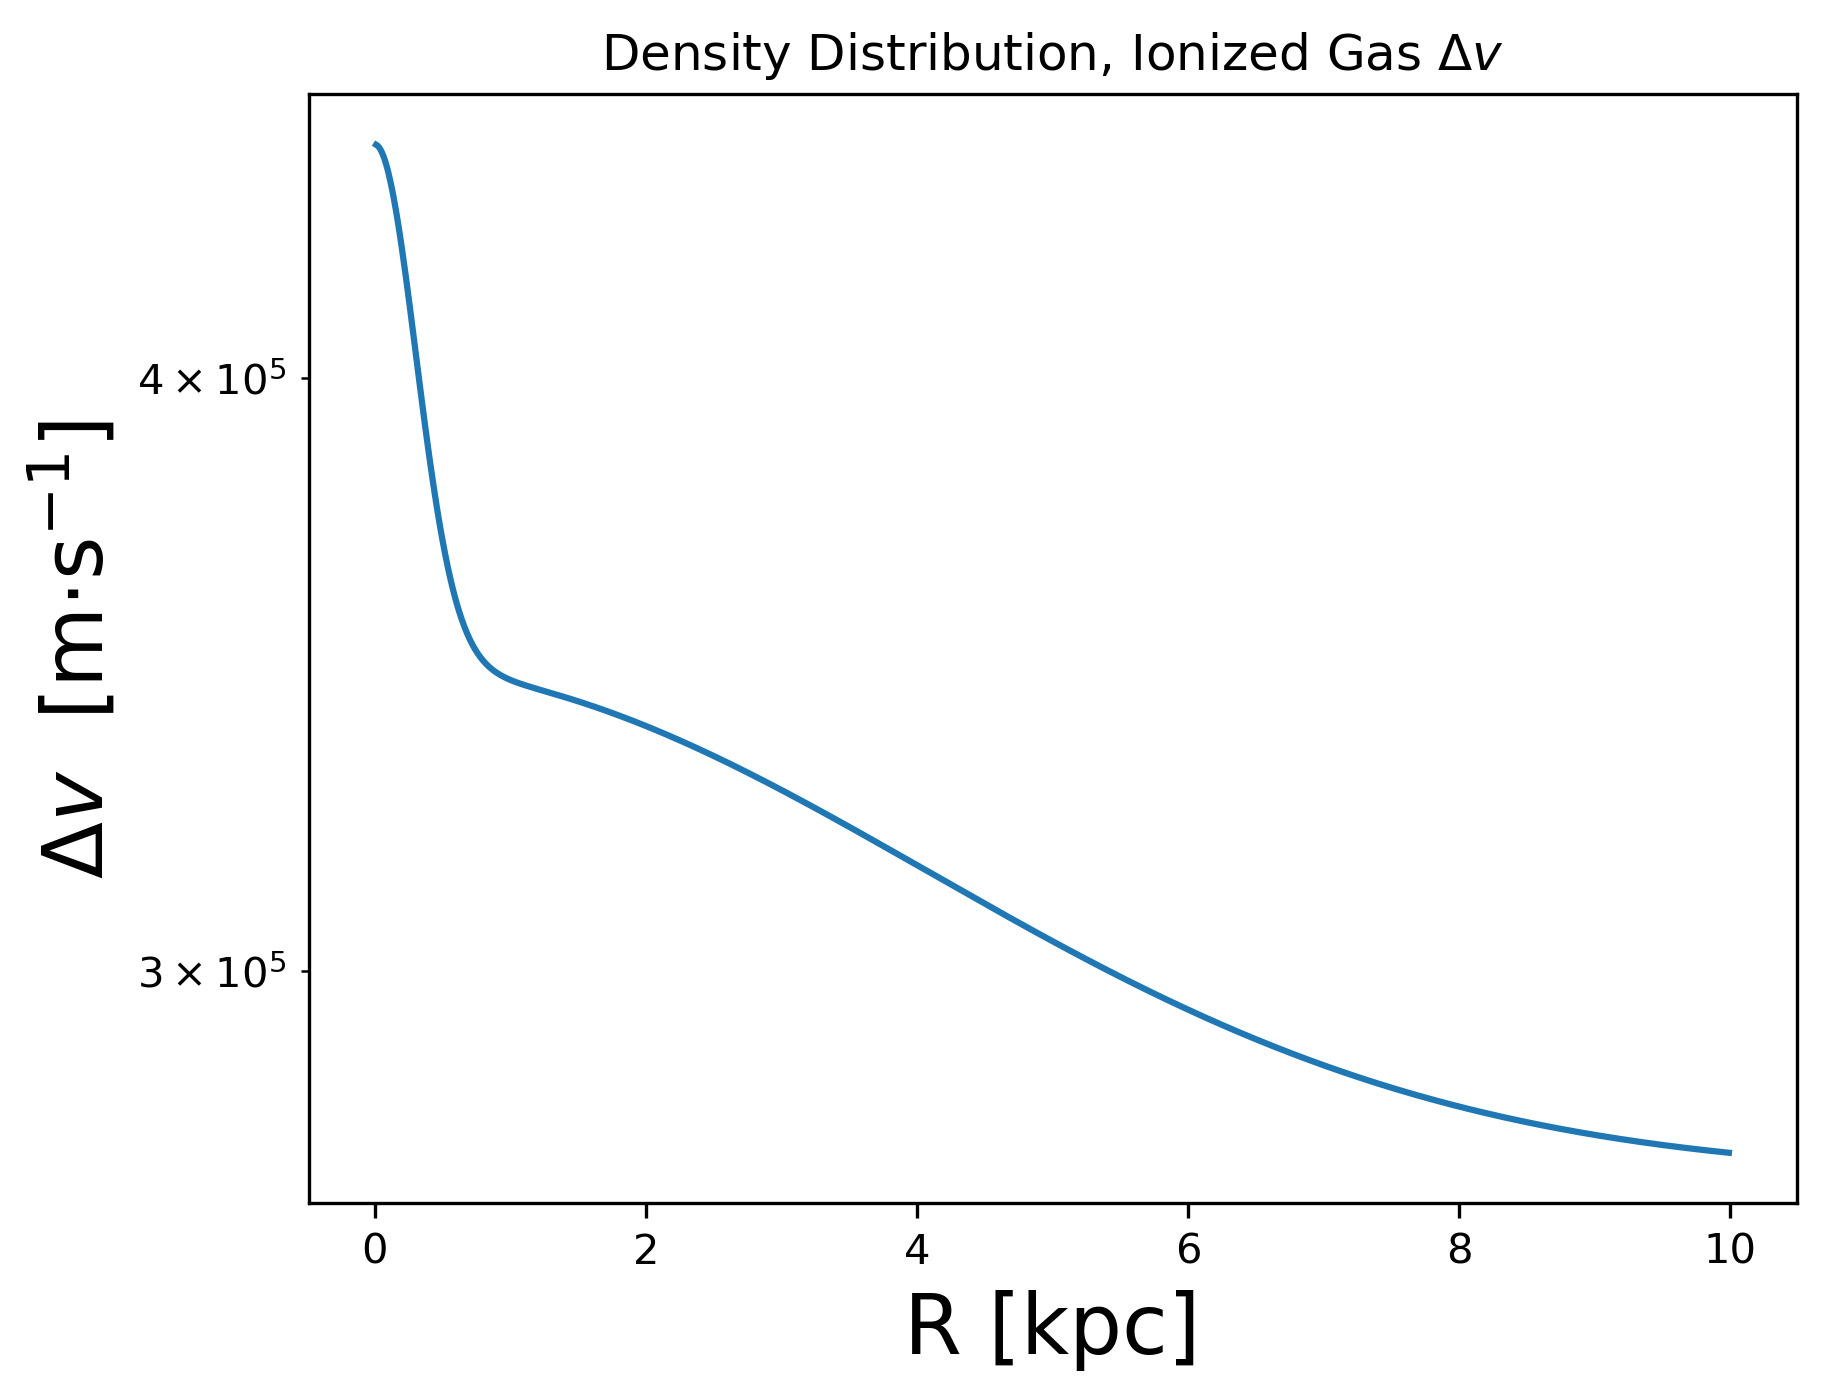

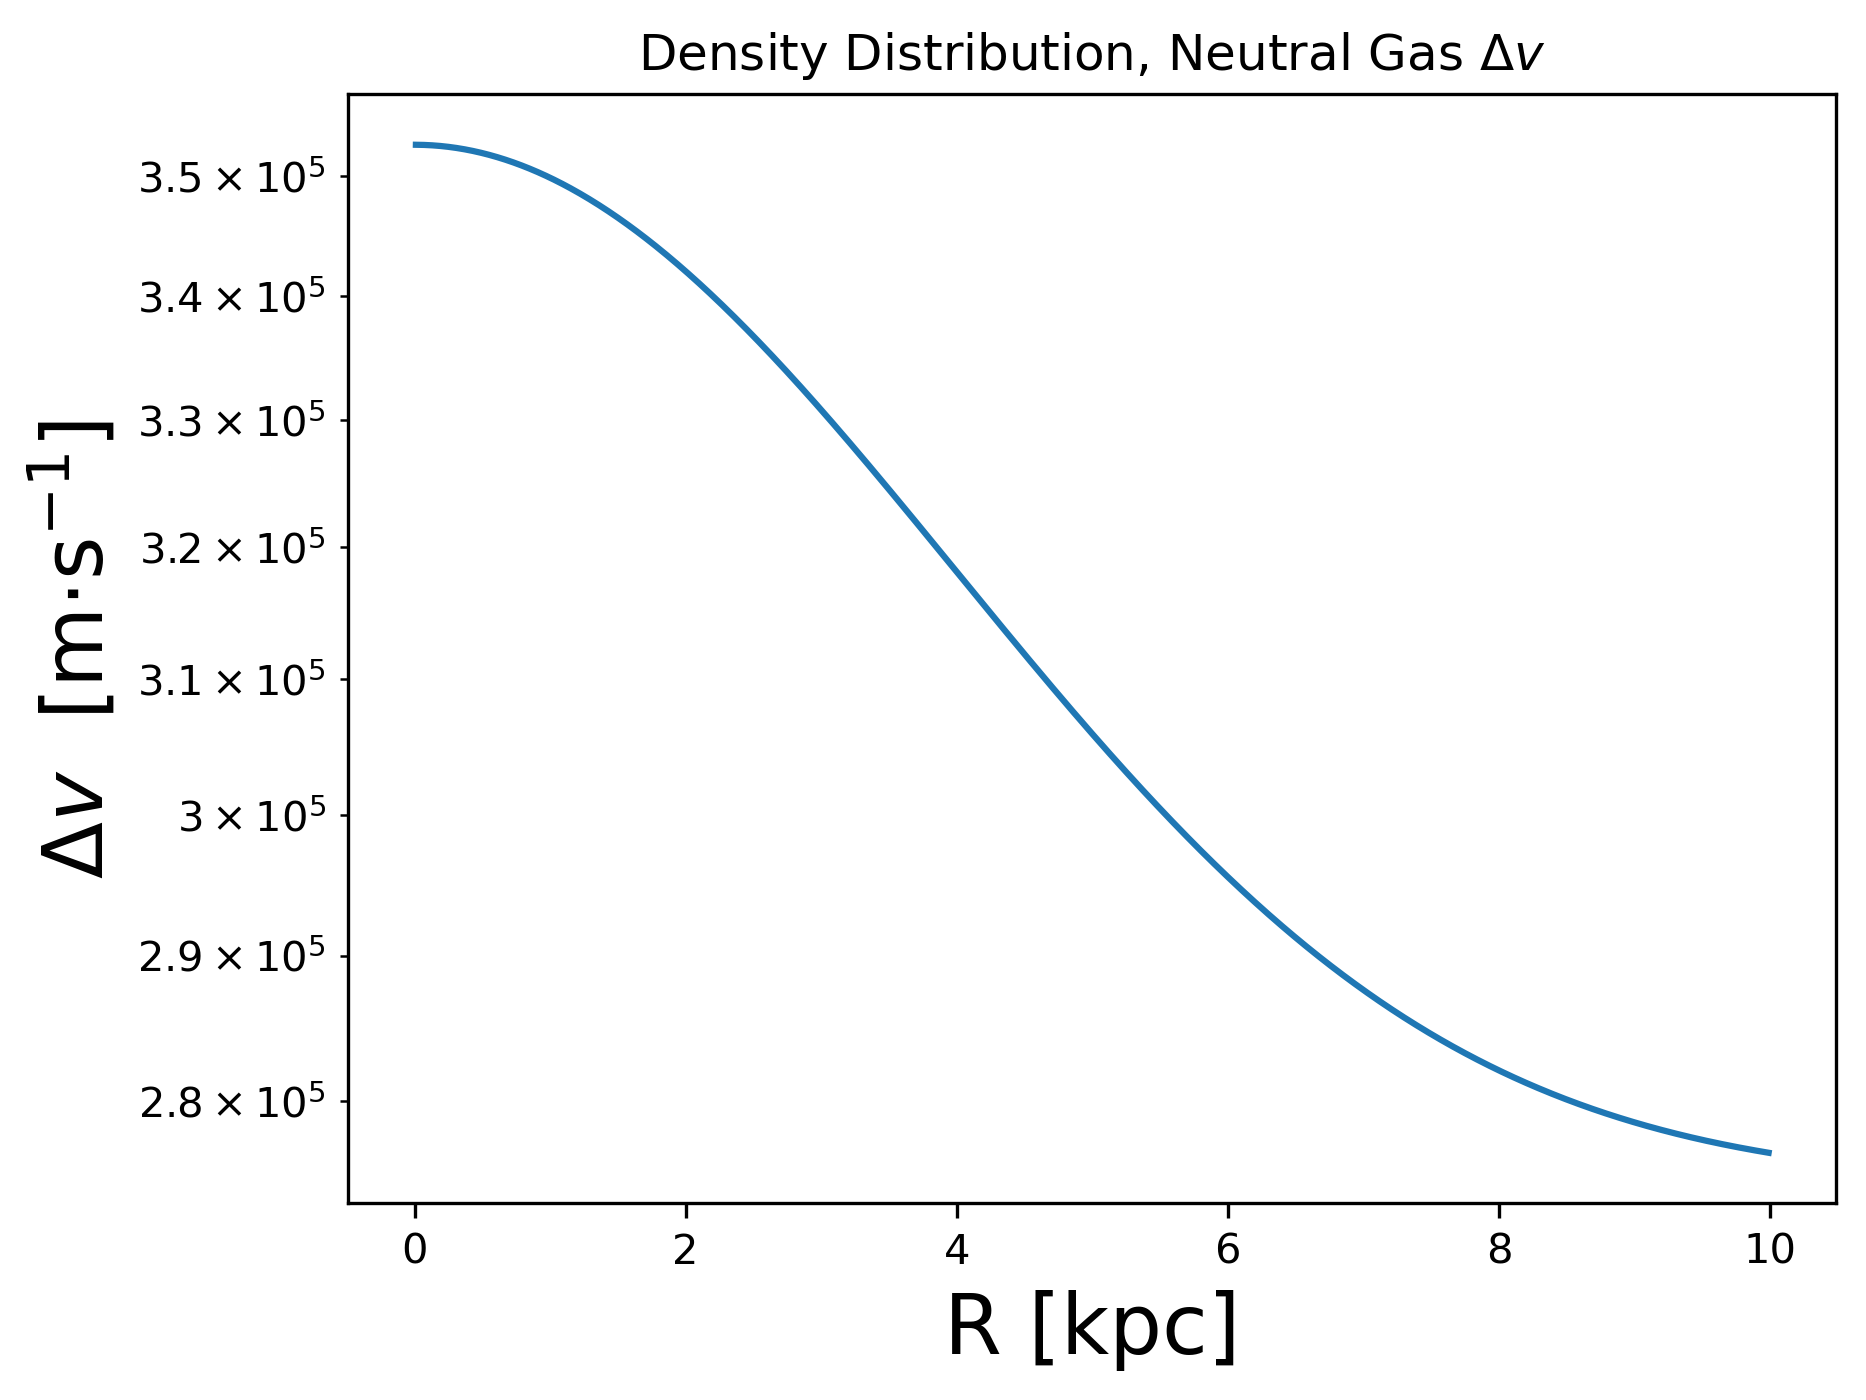

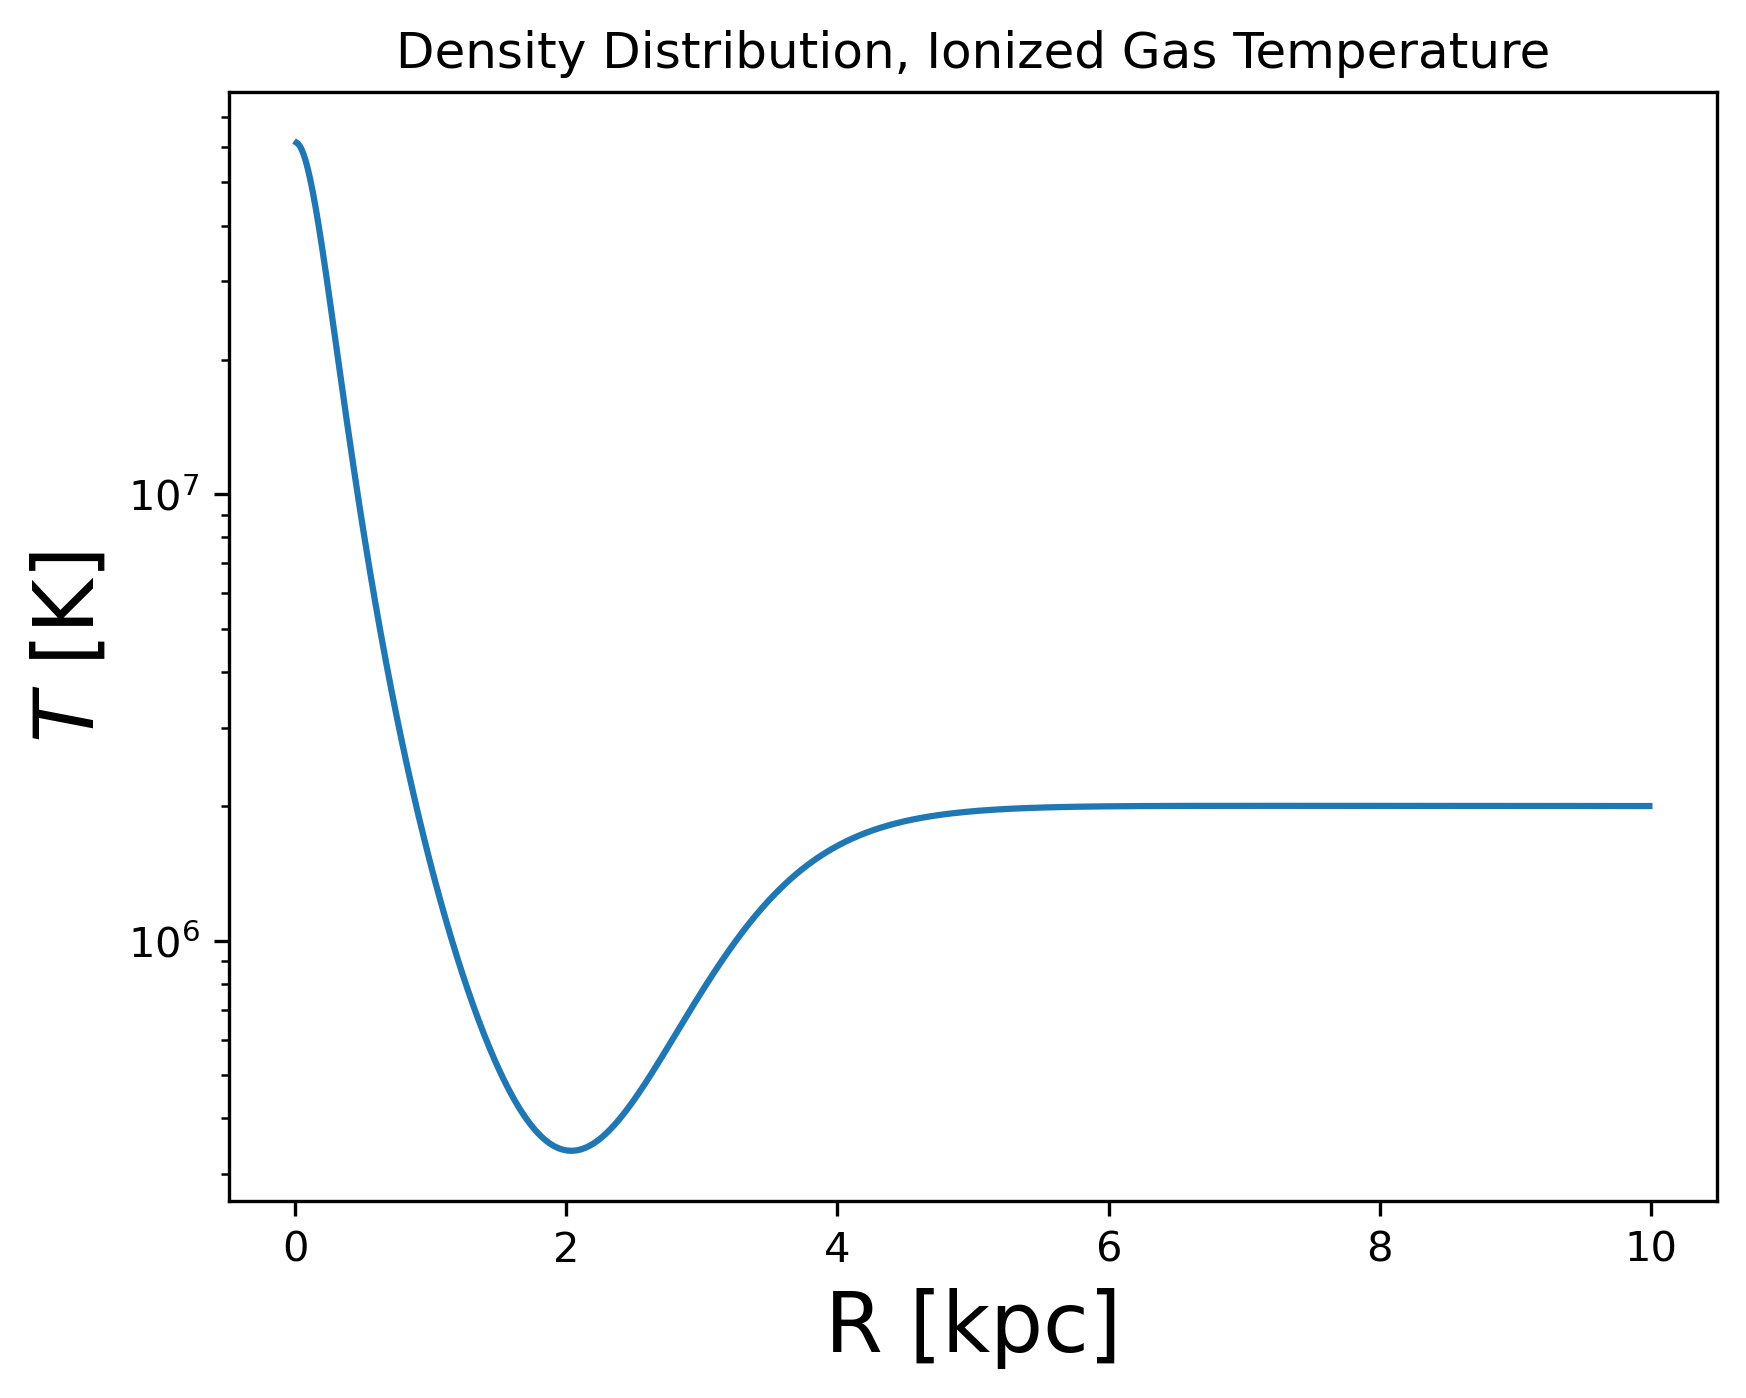

In [22]:
R = np.arange(0.01,10,0.01)
plot_distribution(rho_dark_mat, R, [19.60758081904341, 1.081829387522867, 
                                    2.207828893849368, 1.831142772499595, 
                                    0.06711443461154958], "Dark Matter")

plot_distribution(rho_ioni_gas, R, [6.521713155920115 , 0.2940077939925656, 
                                    29.072973590609415, 1.6812716453492722, 
                                    3.9044895415071528, 3.4656473013927394, 
                                    1.43427732961435], "Ionized Gas", log=False)

plot_distribution(rho_neut_gas, R, [8.97656111186945  ,2.213270305404448 ,
                                    13.875013340031673,1.5018739204854163,
                                    2.58047607932149  ,1.1680782169590678,29.693878727525025], "Neutral Gas")

plot_distribution(rho_dv_ioni, R, [0.7594266933349966, 2.73608605904013, 
                                     2.5582050186794847, 1.004084602553337, 
                                     1.6631635389592465, 17.152525652652074, 
                                     2.7163675354935055], r"Ionized Gas $\Delta v$", log=True, velocity=True)

plot_distribution(rho_dv_neut, R, [0.7817275122369671, 1.4514477940369448, 
                                     7.670255389377027 , 
                                     2.7444837892336853], r"Neutral Gas $\Delta v$", log=True, velocity=True)

plot_distribution(rho_temp, R, [6.14, 0.3, 1.5, 0.1, 3.3, 0.1], r"Ionized Gas Temperature", log=True, velocity=False, 
                  temperature=True)